In [33]:
from glob import glob
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.layers import concatenate, Dropout, MaxPooling2D, concatenate

In [3]:
train_path = '../input/cityscapes-image-pairs/cityscapes_data/train/'
test_path = '../input/cityscapes-image-pairs/cityscapes_data/val/'
img_idx_train = glob(train_path + '*')
img_idx_test = glob(test_path + '*')

In [4]:
def load_data(batch_size = 16, task = 'train'):
    if task == 'train':
        idx = np.random.choice(img_idx_train, batch_size)
    else:
        idx = np.random.choice(img_idx_test, batch_size)
    x_train, y_train = [], []
    for i in idx:
        img = image.load_img(i)
        img = image.img_to_array(img)
        img = img / 255.0
        h, w, _ = img.shape
        _w = int(w/2)
        img_B, img_A = img[:, _w:, :],img[:, :_w, :]
        x_train.append(img_A)
        y_train.append(img_B)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train, y_train

In [5]:
def UNet(shape):
    
    inputs = Input(shape = (shape))
    s = Lambda(lambda x : x / 255)(inputs)  
    
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(3, (1,1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = UNet((256,256,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [6]:
epochs = 10
batch_size = 8
for i in range(epochs):
    for j in range(len(img_idx_train) // batch_size):
        x_train, y_train = load_data()
        loss = model.train_on_batch(x_train, y_train)
    print('Epoch {}, loss : {}'.format(i+1, loss))

Epoch 1, loss : [0.6121045351028442, 0.36462879180908203]
Epoch 2, loss : [0.5823363661766052, 0.5763511657714844]
Epoch 3, loss : [0.5785500407218933, 0.6110935211181641]
Epoch 4, loss : [0.5649779438972473, 0.6459693908691406]
Epoch 5, loss : [0.5661426782608032, 0.5887050628662109]
Epoch 6, loss : [0.5788624286651611, 0.581573486328125]
Epoch 7, loss : [0.564484179019928, 0.6242218017578125]
Epoch 8, loss : [0.5564500689506531, 0.7193546295166016]
Epoch 9, loss : [0.5464925169944763, 0.6611404418945312]
Epoch 10, loss : [0.5689703226089478, 0.6381158828735352]


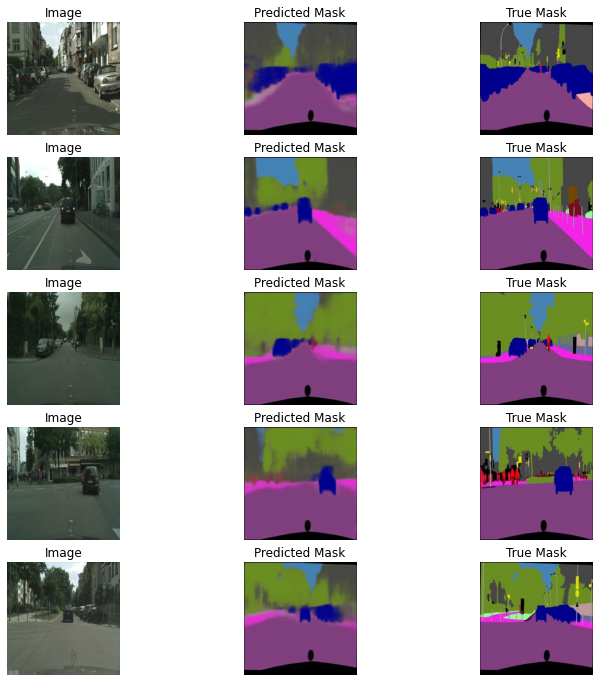

In [76]:
test, true = load_data(batch_size = 100, task = 'val')
pred = model.predict(test)

f, axarr = plt.subplots(5,3, figsize=(12, 12))
for i in range(5):
    axarr[i,0].imshow(test[i])
    axarr[i,0].title.set_text('Image')
    axarr[i,0].axis('off')
    
    axarr[i,1].imshow(pred[i])
    axarr[i,1].title.set_text('Predicted Mask')
    axarr[i,1].axis('off')
    
    axarr[i,2].imshow(true[i])
    axarr[i,2].title.set_text('True Mask')
    axarr[i,2].axis('off')

In [72]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [77]:
iou = iou_coef(true, pred)
dice = dice_coef(true, pred)
print('IoU Score :', iou.numpy())
print('Dice Score :', dice.numpy())

IoU Score : 0.28347903
Dice Score : 0.4412204
